<a href="https://colab.research.google.com/github/sreebalajisree/Fake_News_Detection/blob/main/fake_news_dectetion_BERT_tpu_Without_Domain_Pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About this notebook


Other things to try:

Five-fold cross-mean fusion base 0.97709

Single Fold base 0.974

Five-fold cross-validation, weight fusion 0.9789

In-domain data further pre-training

1. Fine-tune warm_up 0.9794

2. dropout 0.9706

3. Utilize pseudo-tags

4. Label smoothing 0.9790

5: Add Indian language data

6: Five-fold cross-validation, average fusion 0.9814

7: Five-fold cross-validation, weight fusion 0.9789

8: single fold, average fusion

9: single fold, weight fusion, 10: length 130 0.978, 192 0.976



In [27]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
#Python libraries
import os
import copy
import random
from string import digits, punctuation
import re

#Basic EDA libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

#SK-learn libraries
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score, accuracy_score, classification_report

#Tensorflow libraries
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from gc import callbacks

#Transformer libraries
import transformers
from transformers import AutoModel
from transformers import BertTokenizer,BertModel,BertConfig,BertForPreTraining
from transformers import TFAutoModel, AutoTokenizer
from gc import callbacks

#Other NLP libraries
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from gensim.models.word2vec import Word2VecKeyedVectors

AUTO = tf.data.experimental.AUTOTUNE

In [30]:
transformers.__version__

'4.24.0'

In [31]:
fake_train = pd.read_excel("/content/sample_data/data/Constraint_English_Train.xlsx")
fake_valid = pd.read_excel("/content/sample_data/data/Constraint_English_Val.xlsx")
fake_test = pd.read_excel("/content/sample_data/data/Constraint_English_Test_without_labels.xlsx")
fake_external1 = pd.read_excel("/content/sample_data/data/external_1.xlsx")
fake_external2 = pd.read_excel("/content/sample_data/data/external_2.xlsx")
df_pseudo = pd.read_csv("/content/sample_data/data/pseudo_submission.csv")

In [32]:
fake_train.head()

,id,tweet,label
0,1.0,The CDC currently reports 99031 deaths. In gen...,real
1,2.0,States reported 1121 deaths a small rise from ...,real
2,3.0,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4.0,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5.0,Populous states can generate large case counts...,real


In [33]:
fake_valid.head()

,id,tweet,label
0,1.0,Chinese converting to Islam after realising th...,fake
1,2.0,11 out of 13 people (from the Diamond Princess...,fake
2,3.0,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4.0,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5.0,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [34]:
fake_test.head()

,id,tweet
0,1.0,Our daily update is published. States reported...
1,2.0,Alfalfa is the only cure for COVID-19.
2,3.0,President Trump Asked What He Would Do If He W...
3,4.0,States reported 630 deaths. We are still seein...
4,5.0,This is the sixth time a global health emergen...


In [35]:
df_pseudo.head()

,tweet,label
0,Our daily update is published. States reported...,real
1,Alfalfa is the only cure for COVID-19.,fake
2,President Trump Asked What He Would Do If He W...,fake
3,States reported 630 deaths. We are still seein...,real
4,This is the sixth time a global health emergen...,real


## Helper Functions

In [36]:
def seed_everything(seed=0):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASSEED'] = str(seed)
  os.environ['TF_DETERMINSTIC_OPS'] = '1'
  random.seed(seed)

seed=1024
seed_everything(seed)



In [37]:
def fast_encode(texts, tokenizers, chunk_size=256, maxlen=512):
  """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
  """
  tokenizer.enable_truncation(max_length=maxlen)
  tokenizer.enable_padding(max_length=maxlen)
  all_ids = []

  for i in tqdm(range(0, len(texts), chunk_size)):
    text_chunk = texts[i:i+chunk_size].tolist()
    encs = tokenizer.encode_batch(text_chunk)
    all_ids.extend([enc.ids for enc in encs])
  
  return np.array(all_ids)

In [38]:
def regular_encode(texts, tokenizer, maxlen=512):
  encod_dic = tokenizer.batch_encode_plus(texts, return_token_type_ids=False, pad_to_max_length=True, max_length = maxlen)
  return np.array(encod_dic['input_ids'])

In [39]:
def build_model(transformer, max_len=512):
  """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
  """
  input_words_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_words_ids")
  sequence_output = transformer(input_words_ids)[0]
  cls_token = sequence_output[:, 0, :]
  output = Dense(2, activation='softmax')(cls_token)

  model = Model(inputs = input_words_ids, outputs=output)
  model.compile(Adam(lr=5e-6), loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01), metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, average='weighted')])

  return model


In [40]:
#Data preprocessing

def data_process(data):
  for i, label in enumerate(data['label']):
    if(data['label'][i] == "real"):
      data['label'][i] = 1
    else:
      data['label'][i] = 0

In [41]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## TPU Configs

In [42]:
# Detect hardware, return appropriate distribution strategy
#Call the necessary code for tpu

try:
  # TPU detection. No parameters necessary if TPU_NAME environment variable is set
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  print("Running on TPU: ", tpu.master())
except ValueError:
  tpu = None

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
else:
  # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
  strategy = tf.distribute.get_strategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU:  grpc://10.116.100.18:8470


REPLICAS:  8


In [43]:
AUTO = tf.data.experimental.AUTOTUNE

# 50% cross validation
#5 fold cross validation
kfold = KFold(n_splits = 5, random_state = seed, shuffle=True)

#Parameter Configuration

In [44]:
# Configuration
epochs = 8
batch_size = 5 * (strategy.num_replicas_in_sync)
max_len = 140
use_external1 = False
use_external2 = True
use_pseudo = True
use_valid = True
display_plot = True


In [45]:
df_pseudo = pd.concat([df_pseudo['tweet'], df_pseudo['label']], axis=1)
data_process(df_pseudo)

In [46]:
fake_train1 = pd.concat([fake_train['tweet'], fake_train['label']], axis=1)
fake_valid1 = pd.concat([fake_valid['tweet'], fake_valid['label']], axis=1)

# Call the data_processing method
data_process(fake_train1)
data_process(fake_valid1)

if (use_valid):
  fake_train1 = pd.concat([fake_train1, fake_valid1], ignore_index=True)

In [47]:
fake_train1.label.value_counts()

1    4480
0    4080
Name: label, dtype: int64

In [48]:
df_pseudo.head()

,tweet,label
0,Our daily update is published. States reported...,1
1,Alfalfa is the only cure for COVID-19.,0
2,President Trump Asked What He Would Do If He W...,0
3,States reported 630 deaths. We are still seein...,1
4,This is the sixth time a global health emergen...,1


## Load text data into memory

## Build datasets objects

In [49]:
def get_train_dataset(x_data, y_data):
  dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
  dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.shuffle(seed)
  dataset = dataset.cache()
  dataset = dataset.prefetch(AUTO)
  return dataset

def get_valid_dataset(x_data, y_data):
  dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
  dataset = dataset.batch(batch_size)
  dataset = dataset.cache()
  dataset = dataset.prefetch(AUTO)
  return dataset

Learning rate result: 1e-06 to 5e-05 to 2.06e-05


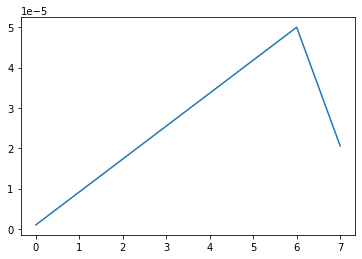

In [50]:
# cosine decay with warm_up
lr_start = 0.00000
lr_max = 0.00005
lr_min = lr_start = 0.000001
lr_rampup_epochs = 6
lr_sustain_epochs = 0
lr_exp_decay = .4

def lr_func(epochs):
  if epochs < lr_rampup_epochs:
    learning_rate = (lr_max - lr_start) / lr_rampup_epochs * epochs + lr_start
  elif epochs < lr_rampup_epochs + lr_sustain_epochs:
    learning_rate = lr_max
  else:
    learning_rate = (lr_max - lr_min) * lr_exp_decay ** (epochs - lr_rampup_epochs - lr_sustain_epochs) + lr_min
  return learning_rate


new_epochs_range = [i for i in range(epochs)]
learning_rate_result = [lr_func(x) for x in new_epochs_range]
print("Learning rate result: {:.3g} to {:.3g} to {:.3g}".format(learning_rate_result[0], max(learning_rate_result), learning_rate_result[-1]))
#plt.xticks(new_epochs_range, "Number of Epochs")
#plt.yticks(learning_rate_result, "Learning rate")
plt.plot(new_epochs_range, learning_rate_result)
plt.show()



In [51]:
lr_warm_up = tf.keras.callbacks.LearningRateScheduler(lr_func, verbose=1)

## Load model into the TPU

## Train Model

First, we train on the subset of the training set, which is completely in English.

#### FOLD 1
use pseudo


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  supe


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/8


225/225 [==============================] - 119s 177ms/step - loss: 0.4608 - accuracy: 0.7823 - f1_score: 0.7811 - val_loss: 0.3174 - val_accuracy: 0.8662 - val_f1_score: 0.8662 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666668e-06.
Epoch 2/8
225/225 [==============================] - 26s 115ms/step - loss: 0.1670 - accuracy: 0.9432 - f1_score: 0.9432 - val_loss: 0.1579 - val_accuracy: 0.9562 - val_f1_score: 0.9561 - lr: 9.1667e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7333333333333336e-05.
Epoch 3/8
225/225 [==============================] - 26s 115ms/step - loss: 0.0916 - accuracy: 0.9777 - f1_score: 0.9777 - val_loss: 0.1089 - val_accuracy: 0.9749 - val_f1_score: 0.9749 - lr: 1.7333e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.5500000000000003e-05.
Epoch 4/8
225/225 [==============================] - 24s 106ms/step - loss: 0.0740 - accuracy: 0.9852 - f1_score: 0.9852 - val_loss: 0.1431 - val_accuracy: 0.

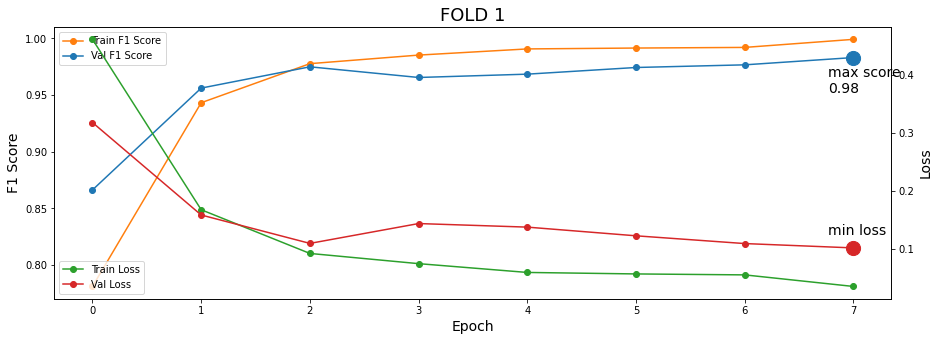

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#### FOLD 2
use pseudo


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  supe


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/8


225/225 [==============================] - 119s 177ms/step - loss: 0.4666 - accuracy: 0.7773 - f1_score: 0.7766 - val_loss: 0.3034 - val_accuracy: 0.8750 - val_f1_score: 0.8745 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666668e-06.
Epoch 2/8
225/225 [==============================] - 26s 115ms/step - loss: 0.1743 - accuracy: 0.9410 - f1_score: 0.9410 - val_loss: 0.1703 - val_accuracy: 0.9463 - val_f1_score: 0.9461 - lr: 9.1667e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7333333333333336e-05.
Epoch 3/8
225/225 [==============================] - 26s 115ms/step - loss: 0.0947 - accuracy: 0.9768 - f1_score: 0.9768 - val_loss: 0.1294 - val_accuracy: 0.9673 - val_f1_score: 0.9673 - lr: 1.7333e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.5500000000000003e-05.
Epoch 4/8
225/225 [==============================] - 24s 107ms/step - loss: 0.0671 - accuracy: 0.9866 - f1_score: 0.9866 - val_loss: 0.1257 - val_accuracy: 0.

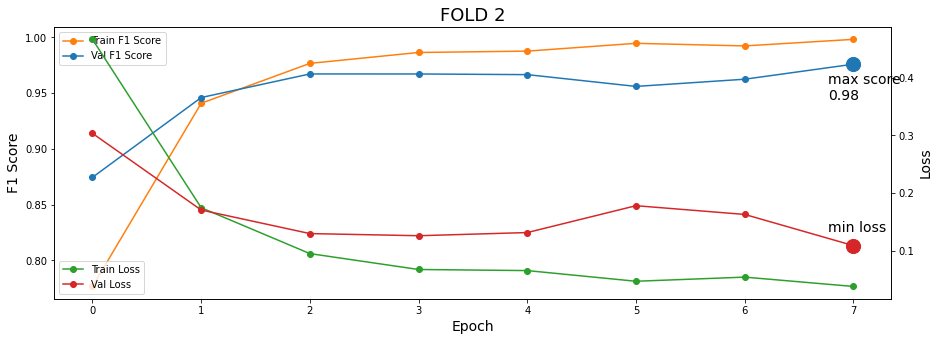

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#### FOLD 3
use pseudo


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  supe


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/8


225/225 [==============================] - 120s 178ms/step - loss: 0.4838 - accuracy: 0.7612 - f1_score: 0.7608 - val_loss: 0.3106 - val_accuracy: 0.8762 - val_f1_score: 0.8761 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666668e-06.
Epoch 2/8
225/225 [==============================] - 26s 116ms/step - loss: 0.1763 - accuracy: 0.9360 - f1_score: 0.9360 - val_loss: 0.1173 - val_accuracy: 0.9679 - val_f1_score: 0.9678 - lr: 9.1667e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7333333333333336e-05.
Epoch 3/8
225/225 [==============================] - 26s 116ms/step - loss: 0.0994 - accuracy: 0.9743 - f1_score: 0.9743 - val_loss: 0.0923 - val_accuracy: 0.9772 - val_f1_score: 0.9772 - lr: 1.7333e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.5500000000000003e-05.
Epoch 4/8
225/225 [==============================] - 26s 117ms/step - loss: 0.0776 - accuracy: 0.9833 - f1_score: 0.9833 - val_loss: 0.0889 - val_accuracy: 0.

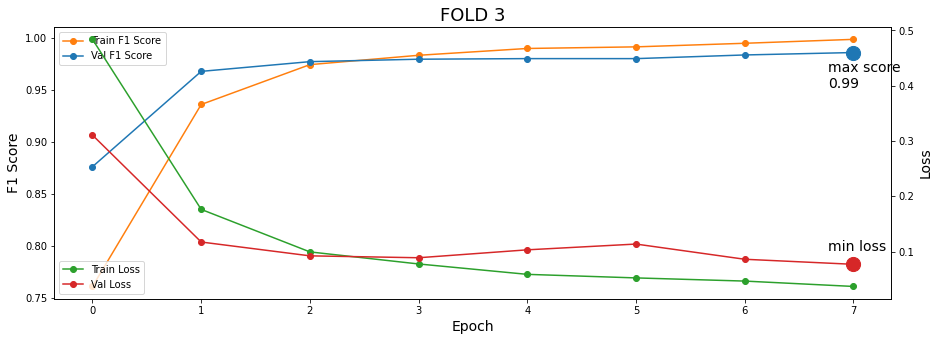

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#### FOLD 4
use pseudo


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
[[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  supe


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/8


225/225 [==============================] - 121s 177ms/step - loss: 0.4579 - accuracy: 0.7820 - f1_score: 0.7814 - val_loss: 0.3238 - val_accuracy: 0.8697 - val_f1_score: 0.8698 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666668e-06.
Epoch 2/8
225/225 [==============================] - 26s 115ms/step - loss: 0.1666 - accuracy: 0.9442 - f1_score: 0.9442 - val_loss: 0.1361 - val_accuracy: 0.9579 - val_f1_score: 0.9580 - lr: 9.1667e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7333333333333336e-05.
Epoch 3/8
225/225 [==============================] - 26s 115ms/step - loss: 0.0944 - accuracy: 0.9769 - f1_score: 0.9769 - val_loss: 0.1395 - val_accuracy: 0.9638 - val_f1_score: 0.9637 - lr: 1.7333e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.5500000000000003e-05.
Epoch 4/8
225/225 [==============================] - 26s 116ms/step - loss: 0.0794 - accuracy: 0.9828 - f1_score: 0.9828 - val_loss: 0.1026 - val_accuracy: 0.

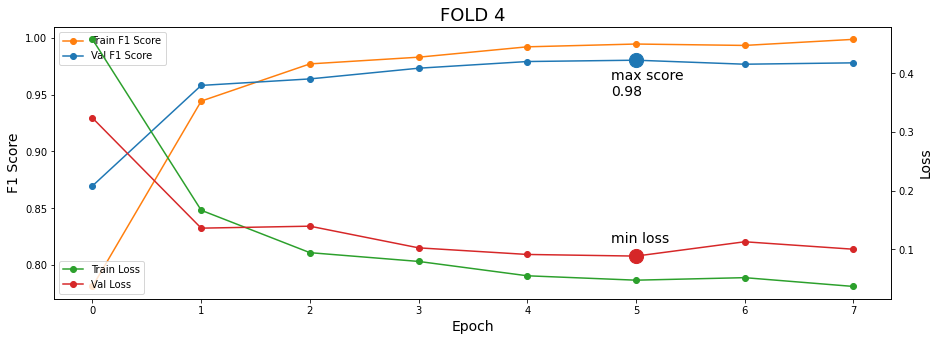

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#### FOLD 5
use pseudo


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  supe


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/8


225/225 [==============================] - 119s 178ms/step - loss: 0.4737 - accuracy: 0.7759 - f1_score: 0.7749 - val_loss: 0.3283 - val_accuracy: 0.8481 - val_f1_score: 0.8471 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666668e-06.
Epoch 2/8
225/225 [==============================] - 26s 116ms/step - loss: 0.1763 - accuracy: 0.9373 - f1_score: 0.9373 - val_loss: 0.1524 - val_accuracy: 0.9451 - val_f1_score: 0.9448 - lr: 9.1667e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7333333333333336e-05.
Epoch 3/8
225/225 [==============================] - 26s 116ms/step - loss: 0.1026 - accuracy: 0.9741 - f1_score: 0.9741 - val_loss: 0.0936 - val_accuracy: 0.9761 - val_f1_score: 0.9761 - lr: 1.7333e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.5500000000000003e-05.
Epoch 4/8
225/225 [==============================] - 24s 108ms/step - loss: 0.0711 - accuracy: 0.9854 - f1_score: 0.9854 - val_loss: 0.0882 - val_accuracy: 0.

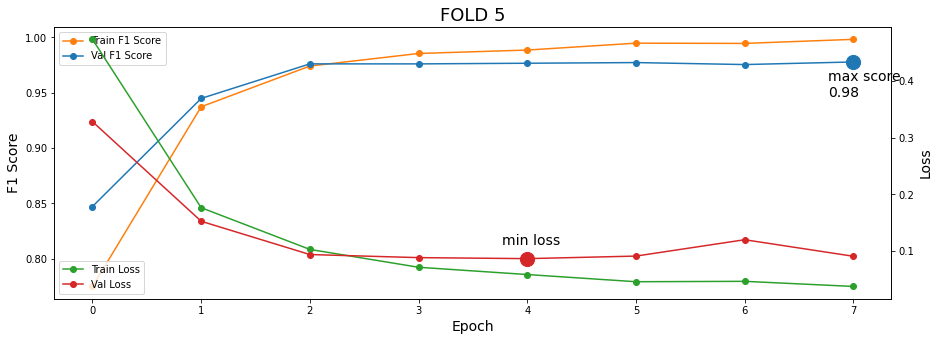

In [52]:
preds = []
weights = []
models = ["bert-base-uncased","distilroberta-base","nghuyong/ernie-2.0-en","bert-base-cased","distilbert-base-uncased"]
for fold,(train,valid) in enumerate(kfold.split(fake_train1.tweet,fake_train1.label)):
    print('#### FOLD',fold+1)
    x_train,x_valid,y_train,y_valid = fake_train1.tweet[train],fake_train1.tweet[valid]\
    ,fake_train1.label[train],fake_train1.label[valid]
    if (use_pseudo):
        print("use pseudo")
        x_train = pd.concat([x_train, df_pseudo.tweet]).reset_index(drop=True)
        y_train = pd.concat([y_train, df_pseudo.label]).reset_index(drop=True)
    if (use_external2):
        x_train = pd.concat([x_train, fake_external2.tweet]).reset_index(drop=True)
        y_train = pd.concat([y_train, fake_external2.label]).reset_index(drop=True)
    
    x_train = x_train.tolist()
    y_train = y_train.tolist()
    y_valid = y_valid.tolist()
    x_valid = x_valid.tolist()

    
    tokenizer = AutoTokenizer.from_pretrained(models[0])
    
    x_fake_train = regular_encode(x_train,tokenizer, maxlen=max_len)
    x_fake_valid = regular_encode(x_valid,tokenizer,maxlen=max_len)

    y_fake_train = to_categorical(y_train,dtype='int32')
    y_fake_valid = to_categorical(y_valid,dtype='int32')

    print(y_fake_train[0:5])
    print(y_fake_valid[0:5])
    
    train_dataset = get_train_dataset(x_fake_train,y_fake_train)
    valid_dataset = get_valid_dataset(x_fake_valid,y_fake_valid)
    
    
    n_steps = x_fake_train.shape[0] // batch_size

    # BUILD MODEL
    K.clear_session()
    tf.tpu.experimental.initialize_tpu_system(tpu)
    with strategy.scope():
        transformer_layer = TFAutoModel.from_pretrained(models[0])
        model = build_model(transformer_layer, max_len=max_len)
    
    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_f1_score', verbose=0, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')
    cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_f1_score', factor = 0.1, patience = 2, verbose = 2, min_delta = 0.0001, mode = 'max')
    
    train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    callbacks = [cb_lr_schedule,sv,lr_warm_up],
    validation_data= valid_dataset, epochs=epochs)
    
    
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)

    fake_train1_list = fake_train1['tweet'].tolist()
    fake_test_list = fake_test['tweet'].tolist()

    print("Type of fake_train1_list: ", type(fake_train1_list))
    print("Type of fake_test_list: ", type(fake_test_list))
    
        
    x_full_train = regular_encode(fake_train1_list, tokenizer, maxlen=max_len)
    
    
    weights.append(model.evaluate(valid_dataset)[2])
    x_fake_test = regular_encode(fake_test_list,tokenizer,maxlen=max_len)
    preds.append(model.predict(x_fake_test))
    
    
    if display_plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(epochs),train_history.history['f1_score'],'-o',label='Train F1 Score',color='#ff7f0e')
        plt.plot(np.arange(epochs),train_history.history['val_f1_score'],'-o',label='Val F1 Score',color='#1f77b4')
        x = np.argmax( train_history.history['val_f1_score'] ); y = np.max( train_history.history['val_f1_score'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max score\n%.2f'%y,size=14)
        plt.ylabel('F1 Score',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(epochs),train_history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(epochs),train_history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( train_history.history['val_loss'] ); y = np.min( train_history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i'%(fold+1),size=18)
        plt.legend(loc=3)
        plt.show()  
        
    del model

In [53]:
def weight_ensemble(weights,predictions):
    weight_sum = np.sum(weights)  
    prediction_sum = 0
    for i in range(len(weights)):
        prediction_sum += (weights[i]/weight_sum)*predictions[i]
    print(prediction_sum)
    np.savez('model_predict_weight',prediction_sum)
    result = np.argmax(prediction_sum,axis=1)
    return result

In [54]:
def mean_ensemble(predictions):
    result = np.argmax(np.mean(predictions,axis=0),axis=1)
    np.savez('model_predict_mean',np.mean(predictions,axis=0))
    return result

In [55]:
weight_result= weight_ensemble(weights,preds)

[[0.00632493 0.993675  ]
 [0.99663544 0.00336461]
 [0.9960377  0.00396229]
 ...
 [0.00632511 0.99367493]
 [0.00498676 0.99501324]
 [0.00607519 0.99392486]]


In [56]:
data1 = np.load('./model_predict_weight.npz')

In [57]:
mean_result = mean_ensemble(preds)
f1_Score= f1_score(np.array(fake_valid1.label,dtype='int32'),mean_result,average='weighted')
f1_Score

0.4803738317757009

In [58]:
result = np.argmax(preds[4],axis=1)
f1_score(np.array(fake_valid1.label,dtype='int32'),result,average='weighted')

0.4803738317757009

In [59]:
def make_submission(result):
    submission = pd.DataFrame(columns=['id','label'])
    submission.label = result
    nlist = range(1,result.shape[0]+1)
    submission.id = nlist
    submission.to_csv('answer.txt', index=False)

In [60]:
make_submission(weight_result)

In [61]:
make_submission(mean_result)

In [62]:
x

4

In [63]:
submission = pd.DataFrame(columns=['id','label'])
submission.label = weight_result
nlist = range(1,weight_result.shape[0]+1)
submission.id = nlist
submission.to_csv('answer.txt', index=False)

In [64]:

MODEL = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

fake_valid_list = fake_valid['tweet'].tolist()

x_fake_valid = regular_encode(fake_valid_list,tokenizer,maxlen=max_len)
x_fake_train = regular_encode(fake_train1_list,tokenizer,maxlen=max_len)



y_fake_train = to_categorical(fake_train1.label,2,dtype='int32')
y_fake_valid = to_categorical(fake_valid1.label,2,dtype='int32')

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=max_len)
model.summary()
n_steps = x_fake_train.shape[0] // batch_size

train_dataset = get_train_dataset(x_fake_train,y_fake_train)
valid_dataset = get_valid_dataset(x_fake_valid,y_fake_valid)
cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_f1_score', factor = 0.5, patience = 3, verbose = 1, min_delta = 0.0001, mode = 'max')
sv = tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5', monitor='val_f1_score', verbose=0, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    callbacks = [cb_lr_schedule,lr_warm_up,sv],
    validation_data= valid_dataset,
    epochs=epochs
    )
print('Loading best model...')
model.load_weights('best_model.h5')
x_fake_test = regular_encode(fake_valid_list,tokenizer,maxlen=max_len)
score = model.evaluate(valid_dataset)
pred = model.predict(x_fake_test)
np.savez('single-model',pred)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_words_ids (InputLayer  [(None, 140)]            0         
 )                                                               
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 140,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_1   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 dense_1 (Dense)             (None, 2)                 1538

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/8
214/214 [==============================] - 75s 115ms/step - loss: 0.4850 - accuracy: 0.7619 - f1_score: 0.7608 - val_loss: 0.3357 - val_accuracy: 0.8463 - val_f1_score: 0.8457 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666668e-06.
Epoch 2/8
214/214 [==============================] - 16s 73ms/step - loss: 0.1970 - accuracy: 0.9292 - f1_score: 0.9292 - val_loss: 0.1584 - val_accuracy: 0.9421 - val_f1_score: 0.9421 - lr: 9.1667e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7333333333333336e-05.
Epoch 3/8
214/214 [==============================] - 16s 73ms/step - loss: 0.0995 - accuracy: 0.9738 - f1_score: 0.9738 - val_loss: 0.0620 - val_accuracy: 0.9897 - val_f1_score: 0.9897 - lr: 1.7333e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.5500000000000003e-05.
Epoch 4/8
214/214 [==============================] - 16s 73ms/step - loss: 0.0713 - acc

In [65]:
f1_score(np.array(fake_valid1.label,dtype='int32'),np.argmax(pred,axis=1),average='weighted')

0.9985980360329745

In [66]:
precision_score(np.array(fake_valid1.label,dtype='int32'),np.argmax(pred,axis=1),average='weighted') 

0.9986018758166125

In [67]:
recall_score(np.array(fake_valid1.label,dtype='int32'),np.argmax(pred,axis=1),average='weighted') 

0.9985981308411215

In [68]:
accuracy_score(np.array(fake_valid1.label,dtype='int32'),np.argmax(pred,axis=1))

0.9985981308411215

In [69]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(score[0],score[1]))

Test set
  Loss: 0.036
  Accuracy: 0.999


(0.0, 0.5074970541521907)

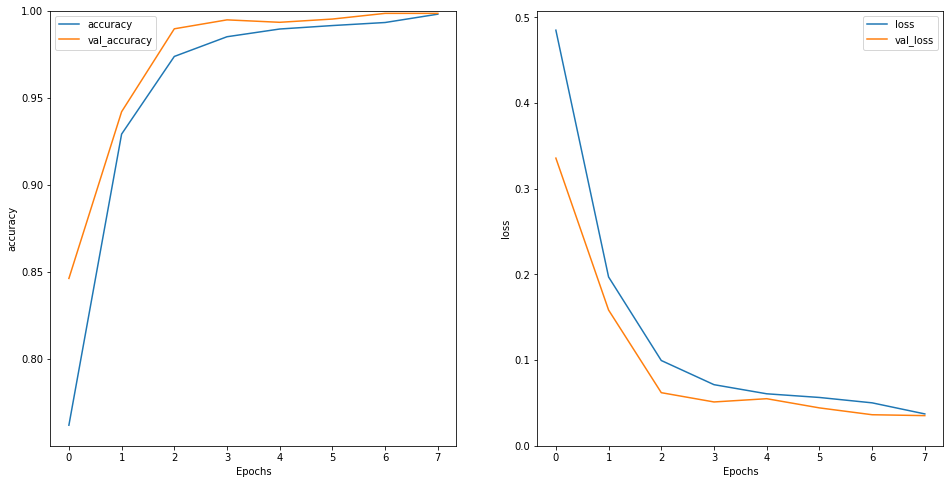

In [70]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(train_history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(train_history, 'loss')
plt.ylim(0, None)

In [71]:
y_valid_label_list = fake_valid1.label.to_list()
len(y_valid_label_list)

2140

#Classification Report

In [72]:
print(classification_report(y_valid_label_list, np.argmax(pred,axis=1), labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1020
           1       1.00      1.00      1.00      1120

    accuracy                           1.00      2140
   macro avg       1.00      1.00      1.00      2140
weighted avg       1.00      1.00      1.00      2140



#Confusion Matrix chart

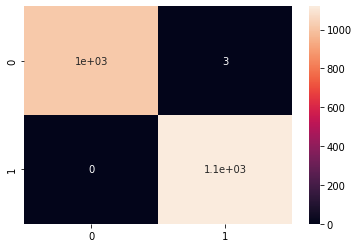

In [73]:
conf_mat = confusion_matrix(y_valid_label_list, np.argmax(pred,axis=1), labels=[0,1])
sns.heatmap(conf_mat, annot=True)

#Result prediction by the model for the given input from fake_test file

In [74]:
new_text = fake_test['tweet'][0]
fake_test_list = [new_text]
x_fake_test_pred = regular_encode(fake_test_list,tokenizer,maxlen=max_len)

new_pred = model.predict(x_fake_test_pred)
labels = ['fake', 'real']

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


1/1 [==============================] - 3s 3s/step


In [75]:
print(new_pred)
print(np.argmax(new_pred))
print(labels[np.argmax(new_pred)])

[[0.00391138 0.9960886 ]]
1
real


In [76]:
print(new_text)

Our daily update is published. States reported 734k tests 39k new cases and 532 deaths. Current hospitalizations fell below 30k for the first time since June 22. https://t.co/wzSYMe0Sht


#Result prediction by the model for the input from fake_external2 file

In [77]:
new_text1 = fake_external2['tweet'][8]
fake_test_list1 = [new_text1]
x_fake_test_pred1 = regular_encode(fake_test_list1,tokenizer,maxlen=max_len)

new_pred1 = model.predict(x_fake_test_pred1)
labels = ['fake', 'real']

1/1 [==============================] - 0s 459ms/step


In [78]:
print(new_pred1)
print(np.argmax(new_pred1))
print(labels[np.argmax(new_pred1)])

[[0.99757904 0.00242102]]
0
fake


In [79]:
print(new_text1)

"SARS-CoV-2 is just a mutated form of the common cold"


In [80]:
fake_external2[5:10]

,tweet,label
5,"""Cats and dogs spread coronavirus""",0
6,"""Face masks always protect against coronavirus""",0
7,"""Hand dryers kill coronavirus""",0
8,"""SARS-CoV-2 is just a mutated form of the comm...",0
9,"""You have to be with someone for 10 minutes to...",0
